<a href="https://colab.research.google.com/github/seonae0223/Deep_Learning/blob/main/05_%EC%B6%9C%EB%A0%A5%EC%B8%B5_%EC%84%A4%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망의 사용처
* 신경망은 분류, 회귀 모두 사용하다.
  * 출력층의 **활성화 함수**에 따라서 목적(사용처)이 달라진다. ( 분류를 할지, 회귀를 할지 )
  * 회귀에서는 항등 함수를 사용하면 회귀가 된다.
* 소프트맥스나 시그모이드 함수를 활용하면 분류
  * 시그모이드는 사용처가 정해져 있음
    * 결괏값을 **확률**로 표현하고 싶을 때 사용한다.
    * 예를 들면 89.12% 확률로 부정적인 리뷰 입니다.
  * 소프트맥스 함수를 주로 분류용 활성화 함수로 사용한다.

# 소프트맥스 함수 구현하기
$$
y_k = \frac{e^{z_k}}{\sum_{i=0}^{n-1} e^{z_i}}
$$

* $k$ : $k$번째 출력 ( 클래스 번호 ) 0, 1, 2 ....
* $z$ : 출력층에 있는 뉴런의 $WX+b$ 연산
* $n$ : 전체 클래스의 개수

In [1]:
import numpy as np

In [3]:
# 출력층의 WX+b를 z라고 가정
z = np.array([0.3, 2.9, 4.0])

# 분자 부분 계산
exp_z = np.exp(z)

# 분모 부분 계산
sum_exp_z = np.sum(exp_z)

pred_y = exp_z / sum_exp_z
pred_y # 소프트맥스 결과

array([0.01821127, 0.24519181, 0.73659691])

In [4]:
np.sum(pred_y)

1.0

# 소프트맥스 함수 튜닝
* 소프트맥스 함수는 자연상수 $e$의 지수 함수
* 입력값이 조금만 커져도 굉장히 큰 값을 연산을 한다.
* 예시
  * $e^{10}$만 되어도 20000이 넘는 수
  * $e^{100}$은 0이 40개가 넘는 큰 숫자
  * $e^{1000}$은 무한대를 의미하는 `inf`

In [5]:
def softmax(z):
  exp_z = np.exp(z) # 분자
  sum_exp_z = np.sum(exp_z) # 분모
  pred_y = exp_z / sum_exp_z
  return pred_y

In [6]:
big_z = [1000, 900, 1100]

softmax(big_z)

<ipython-input-5-b5ee1dba0da1>:2: RuntimeWarning: overflow encountered in exp
  exp_z = np.exp(z) # 분자
<ipython-input-5-b5ee1dba0da1>:4: RuntimeWarning: invalid value encountered in divide
  pred_y = exp_z / sum_exp_z


array([nan, nan, nan])

수학적인 기교로 튜닝이 가능하다.
$$
y_k = \frac{exp(a_k)}{\sum_{i=1}^n exp(a_i)} = \frac{C\,exp(a_k)}{C\,\sum_{i=1}^n exp(a_i)} = \frac{exp(a_k+logC)}{\sum_{i=1}^n exp(a_i+logC)} = \frac{exp(a_k+C^\prime)}{\sum_{i=1}^n exp(a_i+C^\prime)}
$$

In [7]:
# C^prime 이라는 상수는 보통 제일 큰 값에 -1을 곱한 값
# a_k가 각각의 원소

c = np.max(big_z)
big_z + (-c) # -c가 c^prime

array([-100, -200,    0])

In [8]:
# 튜닝된 소프트맥스
def softmax(z):
  c = np.max(z)

  exp_z = np.exp(z - c)
  sum_exp_z = np.exp(exp_z)

  pred_y = exp_z / sum_exp_z
  return pred_y

softmax(big_z)

array([3.72007598e-44, 1.38389653e-87, 3.67879441e-01])

# 텐서플로우 MNIST 데이터 불러오기 & Shape 다루기

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
# mnist 데이터 세트 로딩

from tensorflow.keras import datasets

mnist = datasets.mnist

In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# shape 확인
X_train.shape

(60000, 28, 28)

In [14]:
test_image = X_train[0]
test_image.shape

(28, 28)

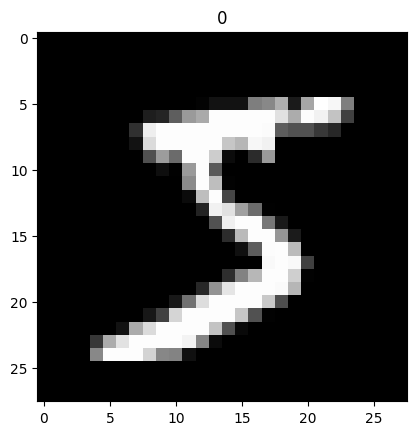

In [15]:
plt.imshow(test_image, 'gray') # 채널에 대한 정보가 없으면 흑백
plt.title(y_train[1])
plt.show()

데이터를 신경망에 넣을 준비 - 훈련, 테스트 모두 동일한 데이터의 feature의 개수를 가져야 한다.
* 신경망은 평평하게 펴진 1차원 배열을 입력으로 받고 있다.
* 즉 지금 우리가 사용할 신경망에 집어 넣을 데이터 1개의 형상은 1차원 배열 형태로 들어가야 한다.
* 평평하게 펴진 데이터를 기반으로 예측을 수행하는 레이어
  * 신경망 - Dense(Linear) Layer
  * 기하학 - Affine Layer
  * 통합적 - F.C Layer ( Fully Connected Layer ) - 전결합( 완전 연결 계층 )
------
신경망에 이미지 데이터를 입력할 수 있는 경우 확인하기
* 장수에 대한 정보 없이 가로 세로 픽셀에 대한 정보만 있는 상황 : `(28, 28)` -> X
* 장수에 대한 정보 없이 평탄화 시킨 상황 : `(784, )` -> O(일단은 허용. Tensorflow나 Pytorch 같은 머신러닝 라이브러리에서는 허용 X)
-----
`60000`장의 이미지 데이터가 `(28, 28)`인 경우. 즉 `(60000, 28, 28)`
* 장수 데이터가 있는 상태에서 가로 세로 픽셀에 대한 정보만 있는 상황 : `(60000, 28, 28)` -> X
* 장수 데이터가 있는 상태에서 평탄화 시킨 상황 : `(60000, 784)` -> O
------
입력되는 데이터의 차원이 `(N, M)`이면 신경망 F.C 레이어에 집어 넣을 수 있다.
* `N` : BATCH_SIZE( 데이터의 개수 )
* `M` : 데이터 스칼라의 개수
  * 배치를 이야기 하지 않는 경우 : `(M, )`
  * 배치를 이야기 하면 : `(N, M)`
  
**참고로 CNN은 Fully Connected Layer가 아니고, 2차원 배치 데이터를 사용하지 않기 때문에 (N, H, W, C)가 됩니다.**

In [16]:
test_image.flatten().shape #1차원 배열 형태로 바뀜

(784,)

In [17]:
test_image.reshape(-1).shape

(784,)

In [18]:
test_image.reshape(1, -1).shape # 맨 앞의 1이라는 숫자가 배치 크기를, 뒤에는 feture의 크기를 의미한다.

(1, 784)